In [1]:
import sys

In [2]:
import gbtoolbox.bounds as bounds
import gbtoolbox.misc as mt
import gbtoolbox.dft as dft
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
print(torch.__version__)
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset

/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2.1.0.dev20230830


In [3]:
N = 80
mult = 2*2
span = 2
x = (np.random.rand(mult*N).reshape(-1,2)*2-1)*span/2.0
y = np.sin(2.1*1*np.pi*x[:,0])*np.sin(3.4*1*np.pi*x[:,1])
xt = (np.random.rand(mult*N*N).reshape(-1,2)*2-1)*span/2.0
yt = np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])

A simple function, easy to understand visually. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


In [5]:
print(torch.backends.cudnn.is_available())
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
False
False


In [6]:
tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(y.reshape(-1,1))
MM=45000
RR=15000

We consider very large networks, ones that definitely have the capacity to approximate the effective target function.

In [7]:
class ShallowRegressor2(nn.Module):
    def __init__(self,SS):
        super(ShallowRegressor2,self).__init__()
        self.fc1 = nn.Linear(2,SS)
        self.fc2 = nn.Linear(SS,1)     
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model2 = ShallowRegressor2(MM)
model2 = model2.to(device)
model2.eval()
tensor_x = tensor_x.to(device)
tensor_y = tensor_y.to(device)
criterion = nn.MSELoss()  # mean square error
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()),lr=0.0001)

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
early_stopper = EarlyStopper(patience=11, min_delta=.1)
for epoch in range(4000):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model2(tensor_x)
    loss = criterion(outputs, tensor_y)
    loss.backward()
    optimizer.step()
    # print statistics
    with torch.no_grad(): 
        outputs = model2(torch.Tensor(xt).to(device))
        vloss = criterion(outputs, torch.Tensor(yt.reshape(-1,1)).to(device))    
    if epoch%50==0:
        print(f'[{epoch + 1}] loss: {loss.item():.3f} vloss: {vloss.item():.3f}')
    if early_stopper.early_stop(vloss):             
        break
print('Finished Training')

[1] loss: 0.225 vloss: 0.419
[51] loss: 0.178 vloss: 0.253
[101] loss: 0.166 vloss: 0.247
[151] loss: 0.154 vloss: 0.243
[201] loss: 0.143 vloss: 0.239
[251] loss: 0.132 vloss: 0.234
[301] loss: 0.121 vloss: 0.229
[351] loss: 0.111 vloss: 0.223
[401] loss: 0.102 vloss: 0.216
[451] loss: 0.093 vloss: 0.209
[501] loss: 0.084 vloss: 0.201
[551] loss: 0.077 vloss: 0.192
[601] loss: 0.069 vloss: 0.184
[651] loss: 0.062 vloss: 0.175
[701] loss: 0.056 vloss: 0.167
[751] loss: 0.050 vloss: 0.158
[801] loss: 0.045 vloss: 0.150
[851] loss: 0.040 vloss: 0.142
[901] loss: 0.036 vloss: 0.135
[951] loss: 0.032 vloss: 0.126
[1001] loss: 0.028 vloss: 0.123
[1051] loss: 0.026 vloss: 0.117
[1101] loss: 0.024 vloss: 0.110
[1151] loss: 0.021 vloss: 0.107
[1201] loss: 0.019 vloss: 0.103
[1251] loss: 0.018 vloss: 0.098
[1301] loss: 0.016 vloss: 0.096
[1351] loss: 0.014 vloss: 0.093
[1401] loss: 0.013 vloss: 0.090
[1451] loss: 0.012 vloss: 0.087
[1501] loss: 0.011 vloss: 0.083
[1551] loss: 0.010 vloss: 0.082

For problems of this type, it is likely that continued training only improves the approximation. Alternatively, training can be stopped early (adjust min_delta and patience ).

In [11]:
print(model2.fc1.weight.shape)
print(model2.fc1.weight)

torch.Size([45000, 2])
Parameter containing:
tensor([[-0.0089, -0.4569],
        [-0.5209, -0.0131],
        [ 0.0201,  0.6122],
        ...,
        [-0.4729,  0.3260],
        [ 0.2130,  0.5961],
        [ 0.6805, -0.6396]], device='cuda:0', requires_grad=True)


In [12]:
print(model2.fc2.weight.shape)
print(model2.fc2.weight)

torch.Size([1, 45000])
Parameter containing:
tensor([[ 0.0015,  0.0022, -0.0179,  ..., -0.0045,  0.0887, -0.0150]],
       device='cuda:0', requires_grad=True)


In [15]:
rng = np.random.default_rng()

In [16]:
selection = rng.choice(MM, RR,replace=False)

We want to consider some smaller network which is a good approximation of the target function but doesn't require as many nodes. This reduction in network size is useful if we want to have the network take less space. Traditional methods of doing this use a larger model to train a smaller in model in model distillation or model compression.

An alternative classical approach is to use matrix concentration (related to the Johnson-Lindenstrauss lemmas and random projections). 

Text(0, 0.5, 'y')

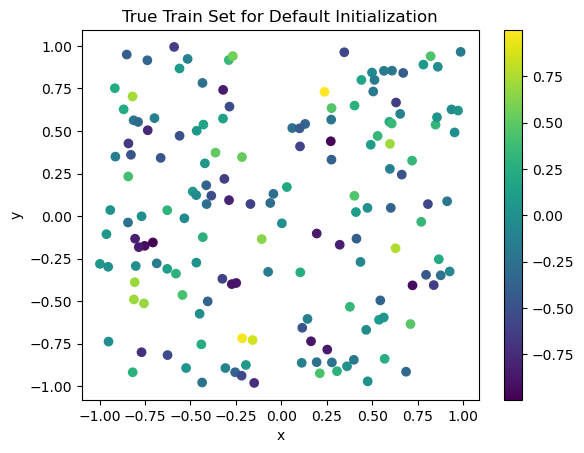

In [17]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.colorbar()
plt.title('True Train Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

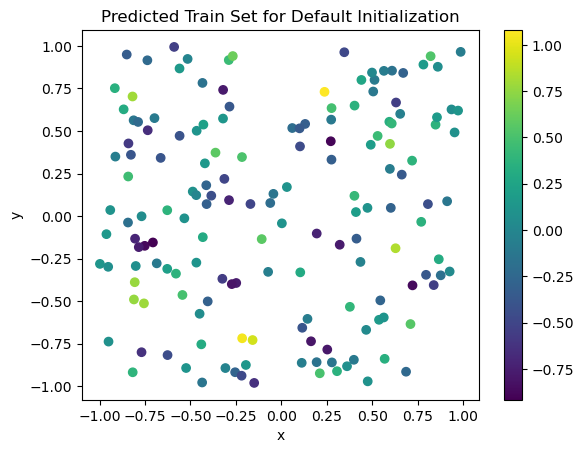

In [18]:
plt.scatter(x[:,0], x[:,1], c=model2(torch.Tensor(x).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Train Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

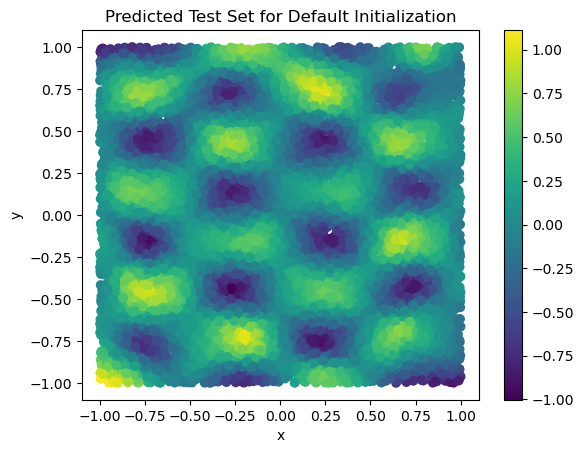

In [19]:
plt.scatter(xt[:,0], xt[:,1], c=model2(torch.Tensor(xt).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

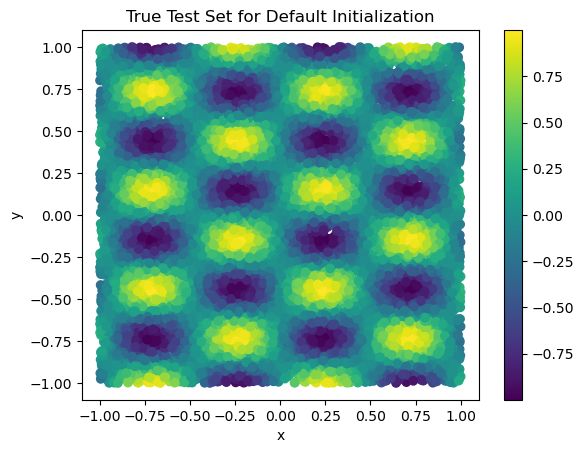

In [20]:
plt.scatter(xt[:,0], xt[:,1], c=yt)
plt.colorbar()
plt.title('True Test Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

Our network provides a pretty good approximation of the target function.

In [21]:
print(model2.fc2.weight[:,selection].shape)
print(model2.fc1.weight[selection,:].shape)
print(model2.fc1.bias[selection].shape)
ref=model2.fc2.weight[:,selection]@F.relu(((model2.fc1.weight[selection,:]@torch.Tensor(xt).to(device).T).T+model2.fc1.bias[selection]).T)

torch.Size([1, 15000])
torch.Size([15000, 2])
torch.Size([15000])


In [22]:
model2.fc1.weight[selection,:].T+model2.fc1.bias[selection]
print(ref)
print(ref.shape)

tensor([[0.3635, 0.2485, 0.0008,  ..., 0.3644, 0.2149, 0.1682]],
       device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 12800])


Text(0, 0.5, 'y')

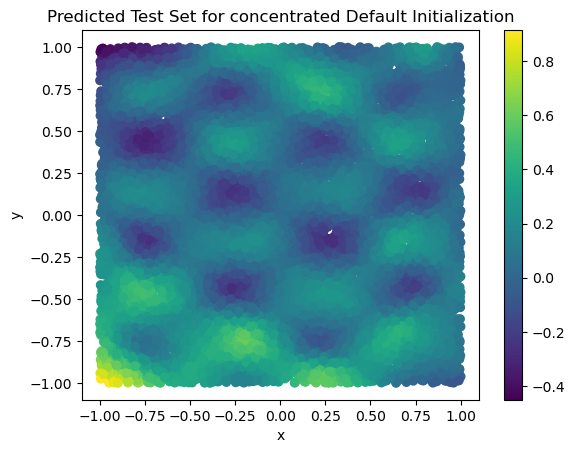

In [23]:
plt.scatter(xt[:,0], xt[:,1], c=ref.detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for concentrated Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

While we observe that this concentrated network shares many of the features of the full network, real information has been lost (and can not just be recovered by scaling).

While we could use this, it would be better to have a non-distorted concentrated model, without further training.

In [24]:
wh1, wn1 = bounds.nn_wnorm(model2.fc1.weight.detach().cpu().numpy().T)
print(wh1.shape)
print(wn1.shape)
print(model2.fc1.weight)
print(torch.Tensor(wh1).to(device))

(2, 45000)
(45000,)
Parameter containing:
tensor([[-0.0089, -0.4569],
        [-0.5209, -0.0131],
        [ 0.0201,  0.6122],
        ...,
        [-0.4729,  0.3260],
        [ 0.2130,  0.5961],
        [ 0.6805, -0.6396]], device='cuda:0', requires_grad=True)
tensor([[-0.0191, -0.9754,  0.0318,  ..., -0.5919,  0.2632,  0.5155],
        [-0.9809, -0.0246,  0.9682,  ...,  0.4081,  0.7368, -0.4845]],
       device='cuda:0')


In [25]:
ref=(model2.fc2.weight.to('cpu')*torch.Tensor(wn1).to('cpu'))@F.relu(((torch.Tensor(wh1).to('cpu').T@torch.Tensor(xt).to('cpu').T).T+model2.fc1.bias.to('cpu')/torch.Tensor(wn1).to('cpu')).T)

Text(0, 0.5, 'y')

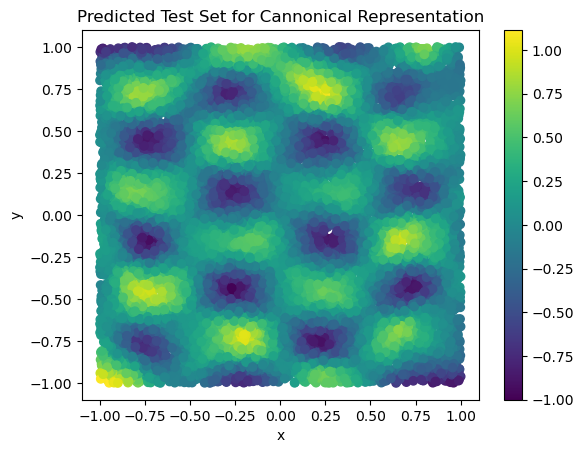

In [26]:
plt.scatter(xt[:,0], xt[:,1], c=ref.detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for Cannonical Representation')
plt.xlabel('x')
plt.ylabel('y')

We can put the network into the canonical form for Fourier analytic Barron space theory. Here we want to have $\sum_i c_i \sigma(\hat{b_i}\cdot x + a_i)$ where $\hat{b}=b/\|b\|_1$. Then the set of $b_i$ and $a_i$ are equivalent to those that would be found from a PDF defined by the Fourier transform of the effective target function.

(45000,) (45000, 1) (45000, 1)


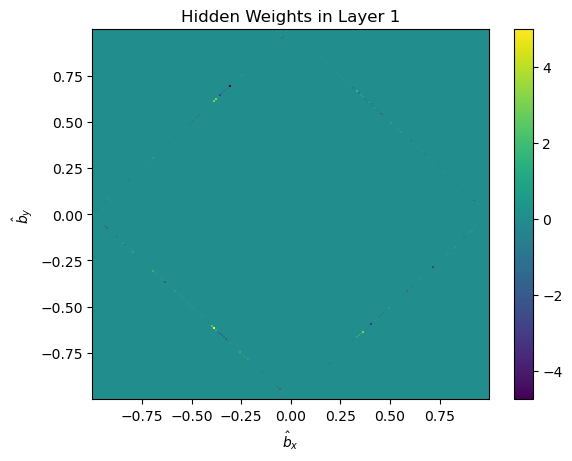

In [27]:
cor_outer_weights=(wn1.T*model2.fc2.weight.detach().cpu().numpy()).T
print(wn1.T.shape,model2.fc2.weight.detach().cpu().numpy().T.shape,cor_outer_weights.shape)
hinfo, xedge, yedge , _ = plt.hist2d(wh1.T[:,0], wh1.T[:,1], bins=200, weights=cor_outer_weights.flatten())
plt.title('Hidden Weights in Layer 1')
plt.xlabel('$\hat{b}_x$')
plt.ylabel('$\hat{b}_y$')
plt.colorbar()

This is similar to the plot that you would find if you did an approximate Fourier transform using the training data.

[[  7  30  36  60  61  61  62  64  64  67  69  74  94 133 135 136 140 145
  171 192]
 [ 92  69  63  39  38 161 162  35 164  32 169  25   5 166  35  36  40 154
   71 107]]
[0.57934687 0.58645814 0.59429389 0.60218482 0.61007833 0.61828442
 0.62663287 0.63532696 0.64423148 0.65339443 0.66310274 0.67314689
 0.68336682 0.69373868 0.7046174  0.71556508 0.7266126  0.73907386
 0.75233876 0.76857558 0.78526665 0.80245792 0.822308   0.84295694
 0.8640217  0.88625249 0.90877726 0.93131489 0.96484374 1.        ]


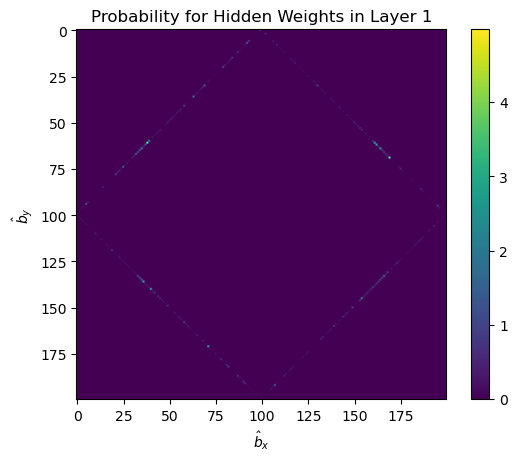

In [45]:
threshold = 1.3
print(np.argwhere(np.abs(hinfo)>threshold).T)
print(((np.sort(np.abs(hinfo).flatten())).cumsum()/np.sum(np.abs(hinfo)))[-30:])
select2=[[xedge[i], yedge[j]] for i,j in np.argwhere(np.abs(hinfo)>threshold)]
plt.imshow(np.abs(hinfo))
plt.title('Probability for Hidden Weights in Layer 1')
plt.xlabel('$\hat{b}_x$')
plt.ylabel('$\hat{b}_y$')
plt.colorbar()

In [46]:
eps = 0.07
wt = np.zeros(wn1.T.shape).astype('bool')
print(wt.shape)
for i in range(len(select2)):
    if i==0:
        wt=np.logical_and(abs(wh1.T[:,0]-select2[i][0])<eps,abs(wh1.T[:,1]-select2[i][1])<eps)
    else:
        wt=np.logical_or(wt,np.logical_and(abs(wh1.T[:,0]-select2[i][0])<eps,abs(wh1.T[:,1]-select2[i][1])<eps))
        
print(wt)

(45000,)
[ True  True False ... False False False]


Here we select the most significant 1/3 of the probability. If we select more, it will be less concentrated and if we select less it will be more concentrated. Obviously if it is too concentrated, at some point we lose crucial components of the model.

Here I set the threshold so that I could have a similar size of network as the earlier concentrated network.

Note that this would be an obvious place to use the very popular technique of quantization. We want to consider the probability in agregate and so we are looking at it binned. We could just use the binned the $\hat{b}$. Considering the Fourier analytic canonical form has the added benefit of making values similar to eachother, in this form weights are going to be initialized close to $1/d$ where $d$ is the feature dimension and in most cases will not be significantly distant.

Since we are not binning or quantizing the $\hat{b}$ here, we need to use an $\epsilon$. I also set $\epsilon$ to make the sizes similar to the earlier concentrated network. In practice, both $\epsilon$ and the threshold need to be set based on the approximate target function. In simple 2-D problems like this one, it is relatively easy to do so by looking at plots like the ones above. For more realistic problems, this would need to be done by looking at the response of the concentrated model to data.

Note that quantization generally moves from FP32 or FP16 to INT8. A concentration that gives a factor of 2 reduction in nodes is going to have similar impact.

In [47]:
print((model2.fc2.weight[:,wt.T].to('cpu')*torch.Tensor(wn1[wt.T]).to('cpu')).shape)
print(((torch.Tensor(wh1[:,wt.T]).to('cpu').T)).shape)
ref=(model2.fc2.weight[:,wt.T].to('cpu')*torch.Tensor(wn1[wt.T]).to('cpu'))@F.relu(((torch.Tensor(wh1[:,wt.T]).to('cpu').T@torch.Tensor(xt).to('cpu').T).T+model2.fc1.bias[wt.T].to('cpu')/torch.Tensor(wn1[wt]).to('cpu')).T)

torch.Size([1, 21264])
torch.Size([21264, 2])


Text(0, 0.5, 'y')

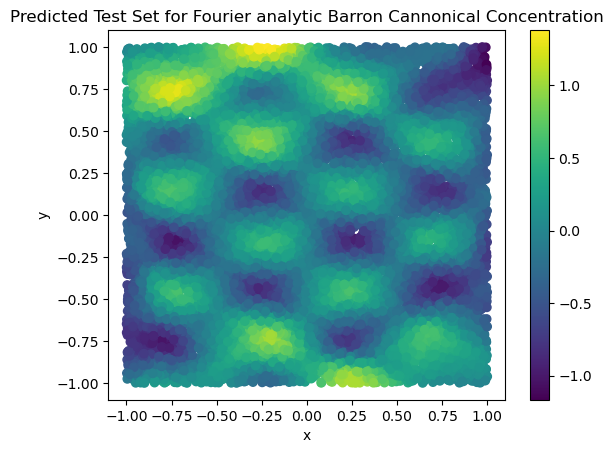

In [48]:
plt.scatter(xt[:,0], xt[:,1], c=ref.detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for Fourier analytic Barron Cannonical Concentration')
plt.xlabel('x')
plt.ylabel('y')

(21264,)


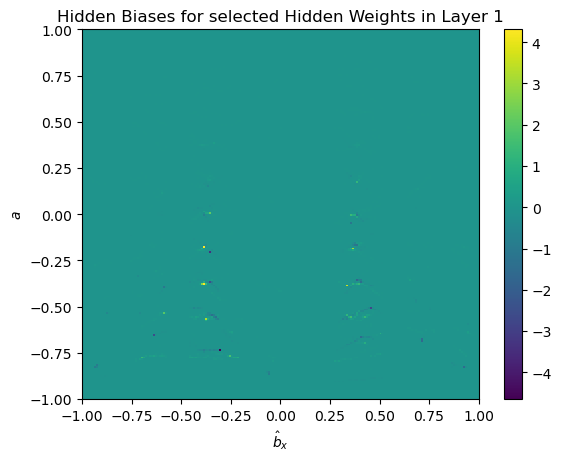

In [49]:
mbias = (model2.fc1.bias[wt.T].to('cpu')/torch.Tensor(wn1[wt]).to('cpu')).detach().numpy()
print(mbias.shape)
hinfoB, xedgeB, yedgeB , _ = plt.hist2d(wh1.T[wt,0], mbias, bins=200, range=[[-1,1],[-1,1]], weights=cor_outer_weights.flatten()[wt])
plt.title('Hidden Biases for selected Hidden Weights in Layer 1')
plt.xlabel('$\hat{b}_x$')
plt.ylabel('$a$')
plt.colorbar()

The PDF in Fourier analytic Barron space theory isn't completely describe by the set of $\hat{b}_i$ but also by the set of $a_i$. If we reconstructed the PDF from both the $a_i$ and $\hat{b}_i$ we could resample and concentrate the weights significantly more (this specific problem could be approximated well with less than 1000 nodes).

We can see the periodic structure in the $a$ and so reconstruct the $\|b\|_1$. While this is easily done visually (or algorithmically) for simple problems like that considered here, it would be much more difficult for more complicated problems.